In [125]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [126]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [127]:
len(words)

32033

In [128]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [129]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
    
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [130]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [230]:
# build the dataset

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:

        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [131]:
C = torch.randn((27, 2))

In [132]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [133]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [134]:
h = torch.tanh(emb.view(-1,6)@W1+b1)

In [135]:
h

tensor([[-1.0000, -0.9999, -0.4926,  ..., -1.0000,  0.9999,  0.9471],
        [-1.0000, -0.9999, -0.8099,  ..., -1.0000,  1.0000,  0.9932],
        [-1.0000, -1.0000,  0.9621,  ..., -0.9812,  0.4437, -0.9993],
        ...,
        [-0.6198, -0.9962, -0.3625,  ..., -0.3309, -0.3783, -0.8517],
        [-0.1087, -0.9995,  0.4339,  ..., -0.9722,  0.9589,  0.6468],
        [ 0.9956,  0.2990, -0.9232,  ..., -0.9669,  0.6289,  0.8289]])

In [136]:
h.shape

torch.Size([228146, 100])

In [137]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)

In [138]:
logits = h @ W2 + b2

In [139]:
logits.shape

torch.Size([228146, 27])

In [140]:
counts = logits.exp()

In [141]:
prob = counts / counts.sum(1, keepdims=True)

In [142]:
prob.shape

torch.Size([228146, 27])

In [145]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [146]:
# ---------- nore made respectable :) -----------

In [245]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182580, 3]), torch.Size([182580]))

In [246]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [247]:
sum(p.nelement() for p in parameters) # number of parameters in total

10281

In [248]:
for p in parameters:
    p.requires_grad = True

In [249]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [250]:
lri = []
lossi = []
stepi = []

for i in range(1000):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr][ix] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    #lr = lrs[i]
    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.item())

print(loss.item())

3.4882428646087646


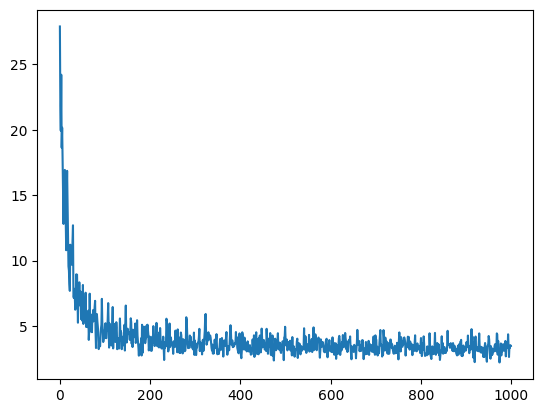

In [251]:
plt.plot(stepi, lossi)

In [252]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(3.2619, grad_fn=<NllLossBackward0>)

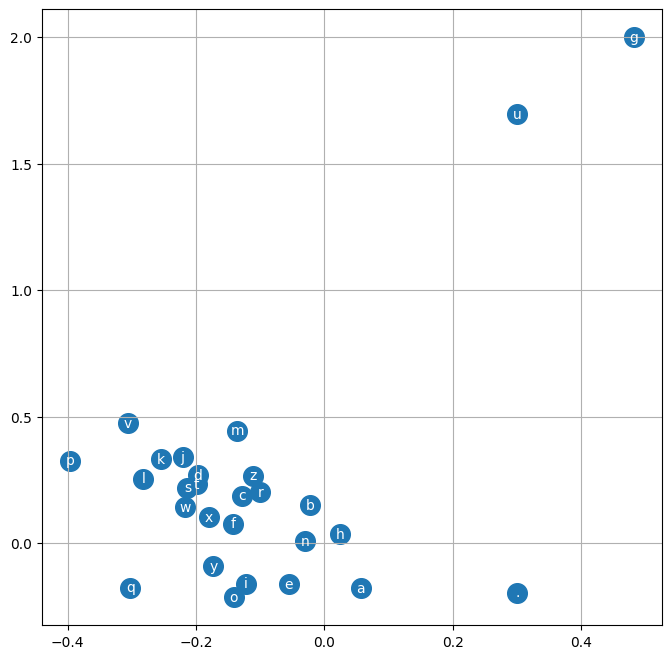

In [253]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')